In [ ]:
 # 1. 필수 라이브러리 설치
# !pip install "pytorch_tabular[all]"

In [ ]:
import pandas as pd
# from google.colab import drive

# 1. 구글 드라이브 마운트
# drive.mount('/content/drive')

# 2. 파일 경로 설정
file_path = '../../DATA/VIP/VIP/VIP_combined_part1.csv'

# 3. CSV 파일을 DataFrame으로 로드
# 한글이 포함된 경로이거나 파일 내용에 한글이 있을 경우를 대비해 encoding='utf-8-sig' 또는 'cp949'를 시도해볼 수 있습니다.
try:
    df = pd.read_csv(file_path)
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='cp949')

# 4. 데이터 확인
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,발급회원번호,기준년월,컨택건수_카드론_TM_B0M,컨택건수_리볼빙_TM_B0M,컨택건수_CA_TM_B0M,컨택건수_이용유도_TM_B0M,컨택건수_신용발급_TM_B0M,컨택건수_부대서비스_TM_B0M,컨택건수_포인트소진_TM_B0M,컨택건수_보험_TM_B0M,...,할인금액_제휴연회비_B0M,청구금액_기본연회비_B0M,청구금액_제휴연회비_B0M,상품관련면제카드수_B0M,임직원면제카드수_B0M,우수회원면제카드수_B0M,기타면제카드수_B0M,카드신청건수,Life_Stage,최종카드발급경과월
0,SYN_501225,201807,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.자녀성장기(1),26
1,SYN_501235,201807,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.가족형성기,32
2,SYN_501238,201807,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.자녀성장기(1),20
3,SYN_501240,201807,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.가족형성기,30
4,SYN_501251,201807,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.자녀성장기(2),50


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# 3. 데이터 정렬 (회원별, 시간순)
# 로드한 df_raw를 df로 복사하여 작업 시작
df = df.sort_values(by=['발급회원번호', '기준년월']).copy()

# 4. 이용금액 합산 및 평균 계산
# 당월 총 이용금액 (신용 + 체크)
df['당월_총_이용금액'] = df['이용금액_신용_B0M'] + df['이용금액_체크_B0M']

# 직전 3개월 평균 이용금액 (신용 R3M + 체크 R3M) / 3
df['직전_3M_평균_이용금액'] = (df['이용금액_신용_R3M'] + df['이용금액_체크_R3M']) / 3

# 5. 이탈 타겟 정의 로직 (Method B)
def define_churn_strict(row):
    # 직전 3개월 평균이 없거나 0원인 경우 -> '판단 제외(휴면/신규)'로 분류
    if pd.isna(row['직전_3M_평균_이용금액']) or row['직전_3M_평균_이용금액'] <= 0:
        return np.nan

    # 직전 평균 대비 10% 미만 사용 시 이탈(1), 아니면 유지(0)
    if row['당월_총_이용금액'] < (row['직전_3M_평균_이용금액'] * 0.8):
        return 1
    else:
        return 0
#@#
df['이탈_타겟'] = df.apply(define_churn_strict, axis=1)

# 6. 데이터 분리 (학습용 vs 휴면/신규 제외용)
# 타겟이 0 또는 1로 확실히 정해진 데이터 (학습용)
train_df = df[df['이탈_타겟'].notna()].copy()
train_df['이탈_타겟'] = train_df['이탈_타겟'].astype(int)

# 타겟이 NaN인 데이터 (별도 관리용: 장기 휴면 또는 신규 고객)
dormant_new_df = df[df['이탈_타겟'].isna()].copy()

# 7. 결과 확인
print("--- [데이터 처리 결과] ---")
print(f"로드된 전체 데이터: {len(df)}건")
print(f"1. 학습 가능 데이터(0, 1): {len(train_df)}건")
print(f"   - 유지(0): {len(train_df[train_df['이탈_타겟'] == 0])}건")
print(f"   - 이탈(1): {len(train_df[train_df['이탈_타겟'] == 1])}건")
print(f"\n2. 판단 제외 데이터(NaN): {len(dormant_new_df)}건 (장기 미사용/신규)")
print("--------------------------")

# 상위 데이터 확인
train_df.head()

--- [데이터 처리 결과] ---
로드된 전체 데이터: 600000건
1. 학습 가능 데이터(0, 1): 578272건
   - 유지(0): 531335건
   - 이탈(1): 46937건

2. 판단 제외 데이터(NaN): 21728건 (장기 미사용/신규)
--------------------------


,발급회원번호,기준년월,컨택건수_카드론_TM_B0M,컨택건수_리볼빙_TM_B0M,컨택건수_CA_TM_B0M,컨택건수_이용유도_TM_B0M,컨택건수_신용발급_TM_B0M,컨택건수_부대서비스_TM_B0M,컨택건수_포인트소진_TM_B0M,컨택건수_보험_TM_B0M,...,상품관련면제카드수_B0M,임직원면제카드수_B0M,우수회원면제카드수_B0M,기타면제카드수_B0M,카드신청건수,Life_Stage,최종카드발급경과월,당월_총_이용금액,직전_3M_평균_이용금액,이탈_타겟
99193,SYN_1000000,201807,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.자녀출산기,20,2016101,2.338494e+06,0
199193,SYN_1000000,201808,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.자녀출산기,21,2147701,2.586017e+06,0
299193,SYN_1000000,201809,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.자녀출산기,22,2188945,2.117582e+06,0
399193,SYN_1000000,201810,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.자녀출산기,23,2475254,2.270633e+06,0
499193,SYN_1000000,201811,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.자녀출산기,24,2235789,2.299996e+06,0


In [ ]:
from sklearn.model_selection import train_test_split

# 1. 유니크한 회원번호(ID) 리스트 추출
unique_ids = train_df['발급회원번호'].unique()

# 2. 회원번호 리스트를 Train/Test 비율(예: 8:2)로 분할
# random_state를 고정하여 실행할 때마다 동일한 분할이 유지되도록 합니다.
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

# 3. 분할된 ID 리스트에 포함된 데이터만 필터링하여 최종 데이터셋 생성
train_final = train_df[train_df['발급회원번호'].isin(train_ids)].reset_index(drop=True)
test_final = train_df[train_df['발급회원번호'].isin(test_ids)].reset_index(drop=True)

# 4. 분할 결과 검증
print("--- [회원번호 기준 분할 결과] ---")
print(f"전체 유니크 회원 수: {len(unique_ids)}명")
print(f"Train 세트: {len(train_ids)}명 ({len(train_final)}건)")
print(f"Test 세트: {len(test_ids)}명 ({len(test_final)}건)")

# 중복 여부 체크 (결과가 0이어야 정상)
overlap = set(train_final['발급회원번호']).intersection(set(test_final['발급회원번호']))
print(f"중복된 회원번호 수: {len(overlap)}개")
print("---------------------------------")

--- [회원번호 기준 분할 결과] ---
전체 유니크 회원 수: 98379명
Train 세트: 78703명 (462685건)
Test 세트: 19676명 (115587건)
중복된 회원번호 수: 0개
---------------------------------


In [ ]:
import torch
from omegaconf.dictconfig import DictConfig
from omegaconf.listconfig import ListConfig

# 에러 메시지에서 요구하는 DictConfig와 ListConfig를 안전 리스트에 추가
torch.serialization.add_safe_globals([DictConfig, ListConfig])
# A100 GPU 성능 최적화 (로그 권장 사항)
torch.set_float32_matmul_precision('high')

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [ ]:
import torch
import typing
import collections
import omegaconf
from omegaconf.dictconfig import DictConfig
from omegaconf.listconfig import ListConfig

# PyTorch 2.6+ 보안 설정 (GLOBAL dict, Any, defaultdict 등 허용)
torch.serialization.add_safe_globals([
    dict, list, set, int, float, str, bool,
    collections.defaultdict,
    DictConfig, ListConfig,
    typing.Any, typing.Union, typing.List, typing.Dict, typing.Optional,
    omegaconf.base.ContainerMetadata, omegaconf.base.Metadata
])
print("✅ 보안 및 오류 방지 설정 완료")

✅ 보안 및 오류 방지 설정 완료


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
from omegaconf.nodes import AnyNode

# PyTorch가 이 객체들을 안전하다고 인식하게 합니다.
torch.serialization.add_safe_globals([AnyNode])

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import pandas as pd
import numpy as np
import os
import torch
from omegaconf.dictconfig import DictConfig
from omegaconf.listconfig import ListConfig

from pytorch_tabular import TabularModel
from pytorch_tabular.models import FTTransformerConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig

# --- [1. 오류 방지 및 최적화 설정] ---
# 1) UnpicklingError(보안 이슈) 방지: omegaconf 객체를 안전한 글로벌 객체로 등록
torch.serialization.add_safe_globals([DictConfig, ListConfig])

# 2) A100 등 최신 GPU 사용 시 연산 정밀도 최적화
torch.set_float32_matmul_precision('high')

# --- [2. 변수 및 경로 설정] ---
target_col = '이탈_타겟'  # 혹은 'Target' (데이터셋의 실제 컬럼명에 맞춰 확인 필요)

# 제외할 컬럼 리스트 (Leakage 방지 및 ID성 컬럼)
제외_컬럼 = ['발급회원번호', '기준년월', '이용금액_신용_BOM', '이용금액_체크_BOM', '이용금액_신용_R3M', '이용금액_체크_R3M',
             '이용금액_신용_B0M', '이용금액_체크_B0M']

# 실제 사용할 피처 선택
feature_columns = [c for c in train_final.columns if c not in 제외_컬럼 and c != target_col]

# 수치형/범주형 자동 분류
categorical_columns = train_final[feature_columns].select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = [c for c in feature_columns if c not in categorical_columns]

# 저장 경로 설정
base_path = '/content/drive/MyDrive/원본데이터처리/데이터머지/원본데이터_스케일링/VIP/Model'
checkpoint_dir = os.path.join(base_path, 'Checkpoints')
final_model_dir = os.path.join(base_path, 'FT_Transformer_Final_VIP_0108')

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(final_model_dir, exist_ok=True)

# --- [3. 데이터 무결성 처리] ---
# 무한대(inf) 및 결측치(NaN) 처리
train_final = train_final.replace([np.inf, -np.inf], 0).fillna(0)
test_final = test_final.replace([np.inf, -np.inf], 0).fillna(0)

# 타겟 타입을 정수형으로 변환 (분류 모델 필수)
train_final[target_col] = train_final[target_col].astype(int)
test_final[target_col] = test_final[target_col].astype(int)


In [ ]:
print(f"✅ 학습에 사용되는 수치형 변수 개수: {len(numerical_columns)}")
print(f"✅ 학습에 사용되는 범주형 변수 개수: {len(categorical_columns)}")
print(f"✅ 첫 번째 수치형 변수 예시: {numerical_columns[0] if numerical_columns else '없음'}")

✅ 학습에 사용되는 수치형 변수 개수: 857
✅ 학습에 사용되는 범주형 변수 개수: 30
✅ 첫 번째 수치형 변수 예시: 컨택건수_카드론_TM_B0M


INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off


✅ 857개 수치형 변수 표준화 완료
📊 계산된 가중치: 0(유지)=0.5443, 1(이탈)=6.1408


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders


🚀 가중치 적용 FT-Transformer 학습 시작...


INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: FTTransformerModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                  ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ FTTransformerBackbone │  182 K │ train │
│ 1 │ _embedding_layer │ Embedding2dLayer      │ 65.5 K │ train │
│ 2 │ _head            │ LinearHead            │ 12.6 K │ train │
│ 3 │ loss             │ CrossEntropyLoss      │      0 │ train │
└───┴──────────────────┴───────────────────────┴────────┴───────┘

Trainable params: 260 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 260 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 152                                                                                         
Modules in eval mode: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model



✅ 학습 완료! 결과 저장 및 분석을 시작합니다.


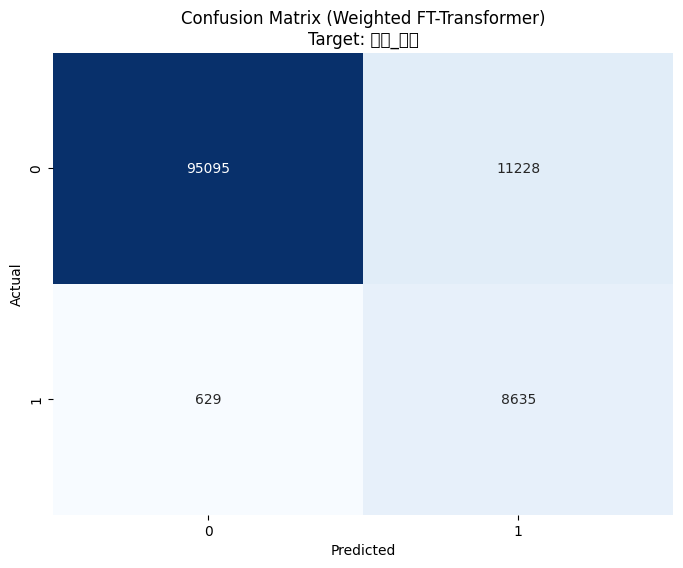

📊 최종 리포트:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    106323
           1       0.43      0.93      0.59      9264

    accuracy                           0.90    115587
   macro avg       0.71      0.91      0.77    115587
weighted avg       0.95      0.90      0.91    115587

📁 모든 결과(모델, 예측CSV, 이미지, 리포트)가 다음 폴더에 저장되었습니다:
/content/drive/MyDrive/원본데이터처리/데이터머지/원본데이터_스케일링/VIP/Model/FT_Transformer_Final_VIP_0108


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from pytorch_lightning.callbacks import Callback

from pytorch_tabular import TabularModel
from pytorch_tabular.models import FTTransformerConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig

# ---------------------------------------------------------
# [1] 데이터 수치 표준화 (Standardization)
# ---------------------------------------------------------
# Deep Learning 모델인 FT-Transformer의 수치 안정성을 위해 표준화를 권장합니다.
scaler = StandardScaler()
train_final[numerical_columns] = scaler.fit_transform(train_final[numerical_columns])
test_final[numerical_columns] = scaler.transform(test_final[numerical_columns])

print(f"✅ {len(numerical_columns)}개 수치형 변수 표준화 완료")

# ---------------------------------------------------------
# [2] 클래스 가중치 계산 (불균형 해소)
# ---------------------------------------------------------
y_train = train_final[target_col].values
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
weights_tensor = torch.tensor(weights, dtype=torch.float)

print(f"📊 계산된 가중치: 0(유지)={weights[0]:.4f}, 1(이탈)={weights[1]:.4f}")

# ---------------------------------------------------------
# [3] 가중치 주입을 위한 SafeLossWeightCallback 정의
# ---------------------------------------------------------
class SafeLossWeightCallback(Callback):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights

    def on_train_start(self, trainer, pl_module):
        # print 문을 제거하여 로그 폭발 방지
        device = pl_module.device
        if not isinstance(pl_module.loss, nn.CrossEntropyLoss) or pl_module.loss.weight is None:
            pl_module.loss = nn.CrossEntropyLoss(weight=self.weights.to(device))


# ---------------------------------------------------------
# [4] 모델 설정 (Configs)
# ---------------------------------------------------------
data_config = DataConfig(
    target=[target_col],
    continuous_cols=numerical_columns,
    categorical_cols=categorical_columns,
)

model_config = FTTransformerConfig(
    task="classification",
    num_heads=8,
    num_attn_blocks=4,
    learning_rate=1e-5,
    head="LinearHead",
    head_config={"layers": "128-64", "dropout": 0.1},
)

trainer_config = TrainerConfig(
    batch_size=64,
    max_epochs=15,
    early_stopping_patience=3,
    gradient_clip_val=0.5,           # 그래디언트 클리핑으로 수치 안정성 확보
    checkpoints="valid_loss",
    checkpoints_path=checkpoint_dir,
    load_best=True
)

# TabularModel 초기화
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=OptimizerConfig(),
    trainer_config=trainer_config,
)

# ---------------------------------------------------------
# [5] 학습 실행
# ---------------------------------------------------------
print("🚀 가중치 적용 FT-Transformer 학습 시작...")
tabular_model.fit(
    train=train_final,
    validation=test_final,
    callbacks=[SafeLossWeightCallback(weights_tensor)]
)

# ---------------------------------------------------------
# [6] 학습 완료 후 자동 저장 및 분석
# ---------------------------------------------------------
print("\n✅ 학습 완료! 결과 저장 및 분석을 시작합니다.")

# 1. 모델 저장
final_save_path = os.path.join(final_model_dir, "final_weighted_ft_transformer")
tabular_model.save_model(final_save_path)

# 2. 예측 수행
predictions = tabular_model.predict(test_final)
csv_save_path = os.path.join(final_model_dir, "test_predictions.csv")
predictions.to_csv(csv_save_path, index=False, encoding='utf-8-sig')

# 3. 혼동 행렬 시각화
y_true = test_final[target_col]
y_pred = predictions[f"{target_col}_prediction"]

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Weighted FT-Transformer)\nTarget: {target_col}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

matrix_save_path = os.path.join(final_model_dir, "confusion_matrix.png")
plt.savefig(matrix_save_path)
plt.show()

# 4. 성능 리포트 출력 및 저장
report = classification_report(y_true, y_pred)
print(f"📊 최종 리포트:\n{report}")

with open(os.path.join(final_model_dir, "classification_report.txt"), "w") as f:
    f.write(report)

print(f"📁 모든 결과(모델, 예측CSV, 이미지, 리포트)가 다음 폴더에 저장되었습니다:\n{final_model_dir}")